# Lab 6

This lab connects all the pieces involved in training feed-forward fully connected neural networks. You will run a full set of experiments to explore different hyperparameters and hidden layer sizes for both the MNIST and FASHION_MNIST datasets, and report your findings.

In [1]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

## Datasets


### Fashion MNIST

We load the fashion_mnist dataset as before.

Label: t-shirt


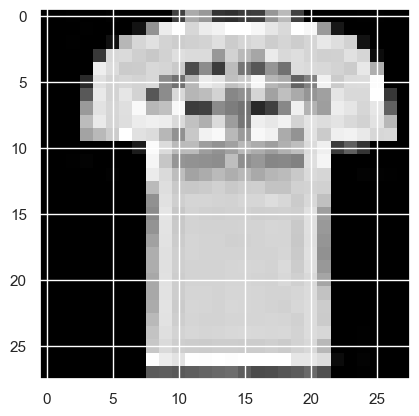

(60000, 28, 28)


In [2]:
from keras.datasets import fashion_mnist

# Load the Fashion MNIST dataset.
(X_train_fashion, Y_train_fashion), (X_test_fashion, Y_test_fashion) = fashion_mnist.load_data()
X_train_fashion = X_train_fashion / 255.
X_test_fashion = X_test_fashion / 255.

# Flatten Y_train and Y_test, so they become vectors of label values.
Y_train_fashion = Y_train_fashion.flatten()
Y_test_fashion = Y_test_fashion.flatten()

label_names = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train_fashion.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train_fashion = X_train_fashion[shuffled_indices]
Y_train_fashion = Y_train_fashion[shuffled_indices]

# Show the first training example.
print('Label: %s' %label_names[Y_train_fashion[0]])
plt.imshow(X_train_fashion[0], cmap='gray')
plt.show()
print(X_train_fashion.shape)

### MNIST

We also load the (digits) mnist dataset in the same way. Note that the number of train/test examples as well as the data shapes are identical to fashion_mnist.

Label: 3


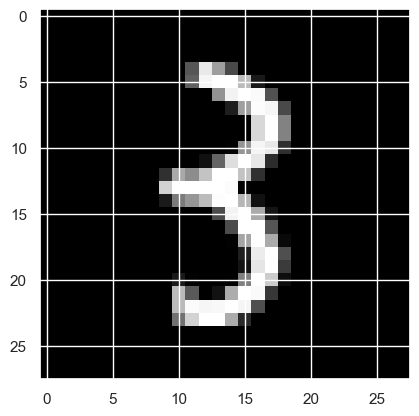

(60000, 28, 28)


In [3]:
from keras.datasets import mnist

# Load the MNIST dataset.
(X_train_digits, Y_train_digits), (X_test_digits, Y_test_digits) = mnist.load_data()
X_train_digits = X_train_digits / 255
X_test_digits = X_test_digits / 255

# Flatten Y_train and Y_test, so they become vectors of label values.
Y_train_digits = Y_train_digits.flatten()
Y_test_digits = Y_test_digits.flatten()

# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train_digits.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train_digits = X_train_digits[shuffled_indices]
Y_train_digits = Y_train_digits[shuffled_indices]

# Show the first training example.
print('Label: %d' %Y_train_digits[0])
plt.imshow(X_train_digits[0], cmap='gray')
plt.show()
print(X_train_digits.shape)

## Build a Model

We will write a build_model function that allows for a range of experiments on both datasets.

---
### Exercise 1 (58points)

Fill in code that implements the build_model function, including all the arguments listed in the function definition.

In [4]:
def build_model(n_classes,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01):
    """Build a multi-class logistic regression model using Keras.

    Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.

    Returns:
    model: A tf.keras model (graph).
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    # YOUR CODE HERE
    print('**** activation is ', activation, ' optimizer is ', optimizer, 
          ' hidden layer ', len(hidden_layer_sizes))
    
    # create a Sequential model
    model = keras.Sequential()
    
    # add Input layer, then add the flattened layer
    model.add(tf.keras.layers.Input(shape=(28,28), name='Input'))
    model.add(tf.keras.layers.Flatten(name='Flatten'))   
    
    # first layer with flattened input
    model.add(tf.keras.layers.Dense(units=784, activation=activation, name='fc_1'))
    
    # loop through hidden layers
    i = 2
    for hidden_layer_size in hidden_layer_sizes:
        model.add(tf.keras.layers.Dense(units=hidden_layer_size, 
                                       activation=activation, name='fc_'+str(i)))
        i += 1
    
    # build output layer
    model.add(tf.keras.layers.Dense(units=n_classes, activation='softmax', 
                                        name='output_layer'))
    
   
    # select optimizer 
    if optimizer == 'SGD':
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'Adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=opt, metrics=['accuracy'])
    
    return model

---

## Run Experiments

We can now run a suite of experiments to see how the hyperparameters and layer sizes effect performance. The train_and_evaluate function below can be used to run experiments and retrieve results.

In [5]:
def train_and_evaluate(data='digits',
                       hidden_layer_sizes=[],
                       activation='tanh',
                       optimizer='Adam',
                       learning_rate=0.01,
                       num_epochs=5):

    # Build the model.
    model = build_model(n_classes=10,
                      hidden_layer_sizes=hidden_layer_sizes,
                      activation=activation,
                      optimizer=optimizer,
                      learning_rate=learning_rate)

    # Select the dataset.
    if data == 'digits':
        X_train = X_train_digits
        X_test = X_test_digits
        Y_train = Y_train_digits
        Y_test = Y_test_digits
    elif data == 'fashion':
        X_train = X_train_fashion
        X_test = X_test_fashion
        Y_train = Y_train_fashion
        Y_test = Y_test_fashion
    else:
        raise 'Unsupported dataset: %s' %data

    # Train the model.
    print('Training...')
    history = model.fit(
        x=X_train,
        y=Y_train,
        epochs=num_epochs,
        batch_size=64,
        validation_split=0.1,
        verbose=0)

    # Retrieve the training metrics (after each train epoch) and the final test
    # accuracy.
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    plt.plot(train_accuracy, label='train_accuracy')
    plt.plot(val_accuracy, label='validation accuracy')
    plt.xticks(range(num_epochs))
    plt.xlabel('Train epochs')
    plt.legend()
    plt.show()

    test_accuracy = model.evaluate(x=X_test, y=Y_test, verbose=0,
                                 return_dict=True)['accuracy']
    model.summary()
    return test_accuracy

# print('Test Accuracy: %1.4f' %train_and_evaluate())

**** activation is  tanh  optimizer is  SGD  hidden layer  0
Training...


2022-09-30 10:17:33.732486: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


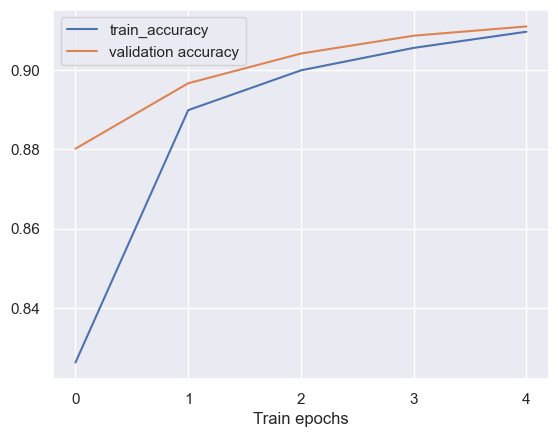

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Flatten (Flatten)           (None, 784)               0         
                                                                 
 fc_1 (Dense)                (None, 784)               615440    
                                                                 
 output_layer (Dense)        (None, 10)                7850      
                                                                 
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________
Test Accuracy: 0.9160 

**** activation is  relu  optimizer is  SGD  hidden layer  0
Training...


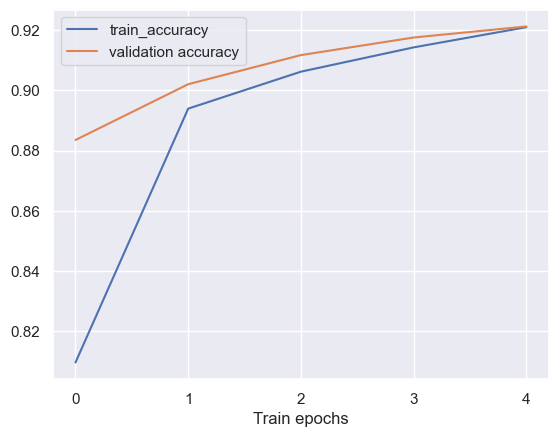

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Flatten (Flatten)           (None, 784)               0         
                                                                 
 fc_1 (Dense)                (None, 784)               615440    
                                                                 
 output_layer (Dense)        (None, 10)                7850      
                                                                 
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________

Test Accuracy: 0.9285 

**** activation is  relu  optimizer is  Adam  hidden layer  0
Training...


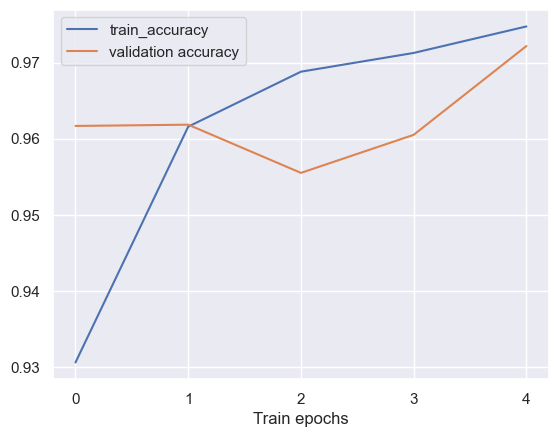

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Flatten (Flatten)           (None, 784)               0         
                                                                 
 fc_1 (Dense)                (None, 784)               615440    
                                                                 
 output_layer (Dense)        (None, 10)                7850      
                                                                 
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________

Test Accuracy: 0.9699 

**** activation is  relu  optimizer is  Adam  hidden layer  1
Training...


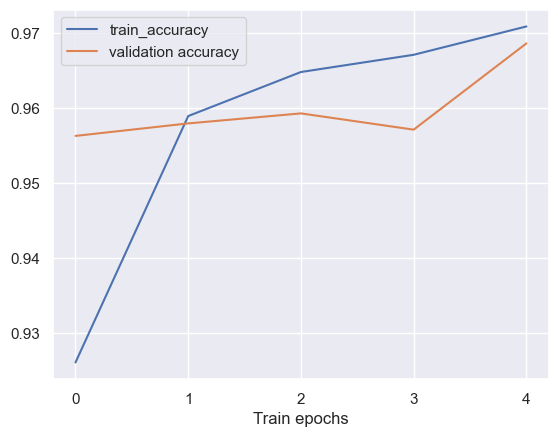

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Flatten (Flatten)           (None, 784)               0         
                                                                 
 fc_1 (Dense)                (None, 784)               615440    
                                                                 
 fc_2 (Dense)                (None, 128)               100480    
                                                                 
 output_layer (Dense)        (None, 10)                1290      
                                                                 
Total params: 717,210
Trainable params: 717,210
Non-trainable params: 0
_________________________________________________________________

Test Accuracy: 0.9702 

**** activation is  relu  optimizer is  Adam  hidden layer  2
Training...


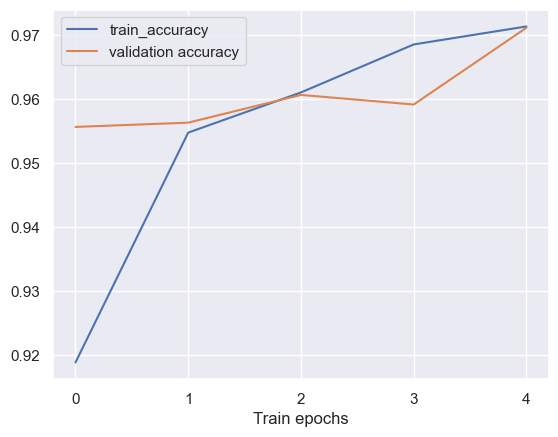

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Flatten (Flatten)           (None, 784)               0         
                                                                 
 fc_1 (Dense)                (None, 784)               615440    
                                                                 
 fc_2 (Dense)                (None, 256)               200960    
                                                                 
 fc_3 (Dense)                (None, 128)               32896     
                                                                 
 output_layer (Dense)        (None, 10)                1290      
                                                                 
Total params: 850,586
Trainable params: 850,586
Non-trainable params: 0
_________________________________________________________________

Test Accuracy: 0.9701 



In [6]:
ta_1 = train_and_evaluate('digits',[],'tanh','SGD',0.01, num_epochs=5)
print('Test Accuracy: %1.4f' %ta_1,'\n')

ta_2 = train_and_evaluate('digits',[],'relu','SGD',0.01, num_epochs=5)
print('\nTest Accuracy: %1.4f' %ta_2,'\n')

ta_3 = train_and_evaluate('digits',[],'relu','Adam',0.01, num_epochs=5)
print('\nTest Accuracy: %1.4f' %ta_3,'\n')

ta_4 = train_and_evaluate('digits',[128],'relu','Adam',0.01, num_epochs=5)
print('\nTest Accuracy: %1.4f' %ta_4,'\n')

ta_5 = train_and_evaluate('digits',[256,128],'relu','Adam',0.01, num_epochs=5)
print('\nTest Accuracy: %1.4f' %ta_5,'\n')

**** activation is  tanh  optimizer is  SGD  hidden layer  0
Training...


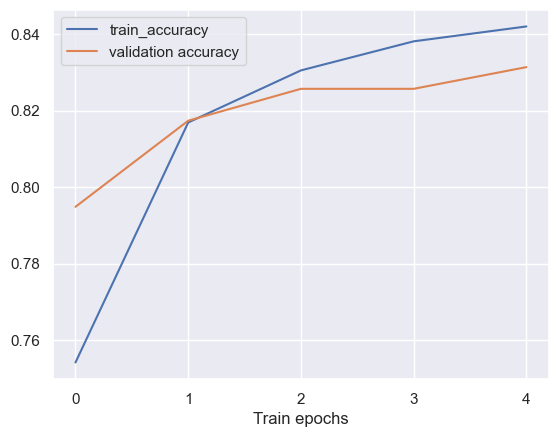

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Flatten (Flatten)           (None, 784)               0         
                                                                 
 fc_1 (Dense)                (None, 784)               615440    
                                                                 
 output_layer (Dense)        (None, 10)                7850      
                                                                 
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________
Test Accuracy: 0.8302 

**** activation is  relu  optimizer is  SGD  hidden layer  0
Training...


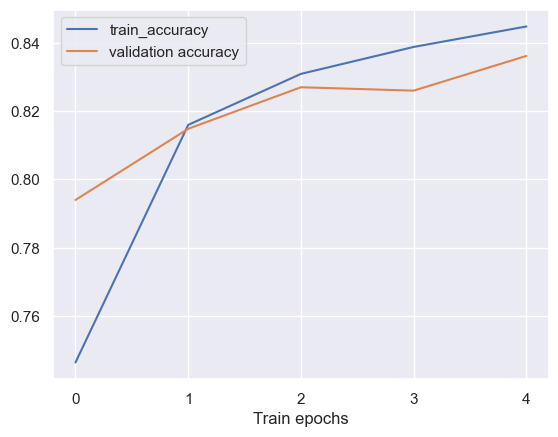

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Flatten (Flatten)           (None, 784)               0         
                                                                 
 fc_1 (Dense)                (None, 784)               615440    
                                                                 
 output_layer (Dense)        (None, 10)                7850      
                                                                 
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________

Test Accuracy: 0.8345 

**** activation is  relu  optimizer is  Adam  hidden layer  0
Training...


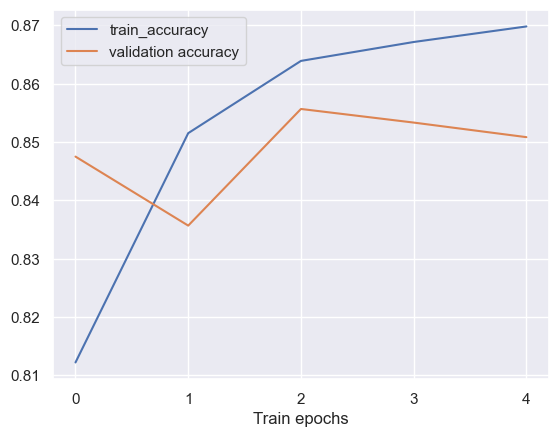

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Flatten (Flatten)           (None, 784)               0         
                                                                 
 fc_1 (Dense)                (None, 784)               615440    
                                                                 
 output_layer (Dense)        (None, 10)                7850      
                                                                 
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________

Test Accuracy: 0.8468 

**** activation is  relu  optimizer is  Adam  hidden layer  1
Training...


In [ ]:
ta_6 = train_and_evaluate('fashion',[],'tanh','SGD',0.01, num_epochs=5)
print('Test Accuracy: %1.4f' %ta_6,'\n')

ta_7 = train_and_evaluate('fashion',[],'relu','SGD',0.01, num_epochs=5)
print('\nTest Accuracy: %1.4f' %ta_7,'\n')

ta_8 = train_and_evaluate('fashion',[],'relu','Adam',0.01, num_epochs=5)
print('\nTest Accuracy: %1.4f' %ta_8,'\n')

ta_9 = train_and_evaluate('fashion',[128],'relu','Adam',0.01, num_epochs=5)
print('\nTest Accuracy: %1.4f' %ta_9,'\n')

ta_10 = train_and_evaluate('fashion',[256,128],'relu','Adam',0.01, num_epochs=5)
print('\nTest Accuracy: %1.4f' %ta_10,'\n')

---
### Exercise 2 (8 points)

Run experiments and fill in the test results in the table below. Feel free to extend the table to more experiments as you see fit.

#### Student Solution

DATA | HIDDEN SIZES | ACTIVATION | OPTIMIZER | LEARNING RATE | #PARAMETERS | TEST ACCURACY
-|-|-|-|-|-|-
digits|[]|tanh|SGD|0.01|623290|0.916
digits|[]|relu|SGD|0.01|623290|0.9285
digits|[]|relu|Adam|0.01|623290|0.9699
digits|[128]|relu|Adam|0.01|717210|0.9702
digits|[256,128]|relu|Adam|0.01|850588|0.9701
-
fashion|[]|tanh|SGD|0.01|623290|0.8302
fashion|[]|relu|SGD|0.01|623290|0.8345
fashion|[]|relu|Adam|0.01|623290|0.8468
fashion|[128]|relu|Adam|0.01|717210|0.8534
fashion|[256,128]|relu|Adam|0.01|850586|0.8485
